In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import time
import datetime
import numpy as np
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
##master = pd.read_csv(r"C:\Users\PC\Documents\ArbAlgo\data\bitmex_hist_data\large_data_2018-07-02_to_2018-09-04.csv")
#master = pd.read_csv(r"C:\Users\PC\Documents\ArbAlgo\data\bitmex_hist_data\large_data_2018-06-30_to_2018-09-12_today.csv")
#unnamed_cols = [x for x in list(master.columns) if "Unnamed" in x]
#try:
#    master = master.drop(unnamed_cols,axis=1)
#except:
#    None
#master.head()

In [83]:
start = datetime.datetime(2019,1,7).date() #(2018,9,21) earliest
end = datetime.datetime.now().date()
end = datetime.datetime(2019,1,8).date()
#################################################
date = start
master = pd.DataFrame()
while date <= end:
    try:
        try:
            data = pd.read_csv(r"C:\Users\PC\GS Trading Dropbox\Bitcoin\ArbAlgo\data\deri_data\\"+str(date)+"_perp_fut"+".csv")
        except:
            data = pd.read_csv(r"C:\Users\PC\GS Trading Dropbox\Bitcoin\ArbAlgo\data\deri_data\\"+str(date)+"_perp_fut"+".zip")            
        master = pd.concat([master,data],sort=True)
        print(date)
        clear_output(wait=True)
        date = date+datetime.timedelta(days=1)
    except FileNotFoundError:
        print(date,"not found")
        date = date+datetime.timedelta(days=1)

# remove duplicates of bid ask prices (no real movement)
master[["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]] = master[["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]].astype(float)
price_cols = ["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]
shift_col_names = [x+"_shift" for x in price_cols]
dup_col_names = [x+"_dup" for x in price_cols]

master[shift_col_names] = master[price_cols].shift(1)

print("size before dup drop",len(master))
for col in price_cols:
    master[col+"_dup"] = master[col] - master[col+"_shift"]
master["dups"] = master[dup_col_names].sum(axis=1)
master = master[master["dups"] != 0]
master.drop(["dups"]+shift_col_names+dup_col_names,axis=1,inplace=True) 
print("size after dup drop",len(master))

## change column names to suit backtester
master.rename({'bid_price_x': 'bidPrice_x',
               'ask_price_x': 'askPrice_x',
               'bid_size_x': 'bidSize_x',
               'ask_size_x': 'askSize_x',
               'bid_price_y': 'bidPrice_y',
               'ask_price_y': 'askPrice_y',
               'bid_size_y': 'bidSize_y',
               'ask_size_y': 'askSize_y',
               'instrument_x': 'symbol_x',
               'instrument_y': 'symbol_y'},inplace=True,axis=1)
master.drop("my_utc_time",axis=1,inplace=True)
master = master.sort_values("timestamp")
master = master.reset_index(drop=True)

display(master.head(1))
display(master.tail(1))

size before dup drop 228231
size after dup drop 18960


,askPrice_x,askPrice_y,askSize_x,askSize_y,bidPrice_x,bidPrice_y,bidSize_x,bidSize_y,symbol_x,symbol_y,timestamp
0,4037.5,3953.0,3530,38,4037.0,3952.5,12836,400,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 00:00:24.758000


,askPrice_x,askPrice_y,askSize_x,askSize_y,bidPrice_x,bidPrice_y,bidSize_x,bidSize_y,symbol_x,symbol_y,timestamp
18959,3994.0,3913.5,455,128,3993.5,3913.0,3372,1239,BTC-PERPETUAL,BTC-29MAR19,2019-01-08 23:59:03.252000


### Add in moving average bands, and resample/reconstruct 1min bar data if needed

In [109]:
all_final_results = []
mov_avgs = [150] #[5,10,20,30,50,80,100,300,500,1000,3000,5000]
margins = [0.09] #[0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
for mov_avg in mov_avgs:
    for margin in margins: 
                
        #try:       
        com_data2 = master.copy() #.copy()
        
        com_data2["sell_perp"] = com_data2["bidPrice_x"] - com_data2["askPrice_y"]
        com_data2["buy_perp"] = com_data2["askPrice_x"] - com_data2["bidPrice_y"]
        com_data2["timestamp"] = pd.to_datetime(com_data2["timestamp"])
        
        #### variables ####
        data_type = "bars1m"
        
        if data_type == "ticks":
            mov_avg = 2000
        elif data_type == "bars1m":
            mov_avg = mov_avg
            
        margin = margin/100 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        ## OR if using bollinger band ##
        std_devs = 3 #2.5 roughly equivilent to 0.075 margin
        
        ### fees #########
        taker = np.mean([0.05,0.075])/100
        maker = np.mean([-0.025,0.02])/100
        fee = (taker+maker)
        ###################################
        ##workings out ##
        #btc = 6720
        #fee = btc*taker*2
        #profit = btc*margin
        
        if data_type == "ticks":
            ### this is the same calculation as
            spread_mid_avg = (com_data2["sell_perp"]+com_data2["buy_perp"])/2
            ### this one
            spread_mid_avg = ((com_data2["askPrice_x"] + com_data2["bidPrice_x"])/2) - ((com_data2["askPrice_y"] + com_data2["bidPrice_y"])/2)
            ###########################################################################
            com_data2["spread_mid_avg"] = spread_mid_avg
            ## now calc rolling spread mid
            com_data2["spread_mid_avg_rolling"] = spread_mid_avg.rolling(window=mov_avg, min_periods=mov_avg).mean()
            # shift only the moving average forward to account for look ahead bias
            com_data2["spread_mid_avg_rolling"] = com_data2["spread_mid_avg_rolling"].shift(1)
            ## used to calculate average fee price based on passive entry on ask_x then bid_x on exit and aggreassive entry on ask_y then bid_y on exit. Take the average
            com_data2["price_mid_avg"] = com_data2[["askPrice_x","bidPrice_x","askPrice_y","bidPrice_y"]].mean(axis=1)
            ## cleanup 
            com_data2 = com_data2.dropna(axis=0)
            com_data2 = com_data2.sort_values("timestamp")
            
            
        elif data_type == "bars1m":
            bar_data = com_data2.set_index("timestamp",drop=True).copy()
            
            price_mid_avg = pd.Series(bar_data[["askPrice_x","bidPrice_x","askPrice_y","bidPrice_y"]].resample('1Min').last().ffill().mean(axis=1),name="price_mid_avg")
            perp_buy_avg = pd.Series(bar_data['buy_perp'].resample('1Min').last().ffill(),name = "perp_buy_avg")
            perp_sell_avg = pd.Series(bar_data['sell_perp'].resample('1Min').last().ffill(),name = "perp_sell_avg")
            
            ### combine 1min sampled data from buy and sell
            bar_data = pd.concat([perp_buy_avg, perp_sell_avg,price_mid_avg], axis=1)
            ## create spread mid avg and roll it
            bar_data["spread_mid_avg"] = (bar_data["perp_buy_avg"]+bar_data["perp_sell_avg"])/2
            bar_data["spread_mid_avg_rolling"] = bar_data["spread_mid_avg"].rolling(window=mov_avg, min_periods=mov_avg).mean()
            bar_data["spread_mid_avg_rolling"] = bar_data["spread_mid_avg_rolling"].shift(1)
            bar_data["mov_avg_speed"] = bar_data["spread_mid_avg_rolling"].diff()*mov_avg
            
            ## interestingly now combine the 1min data with the original tick data #####
            cols = ["mov_avg_speed","spread_mid_avg_rolling","price_mid_avg","spread_mid_avg"]
            com_data2 = com_data2.merge(bar_data[cols],how="outer",on="timestamp",sort=True)
            com_data2 = com_data2.sort_values("timestamp")
            ## Leaving the rolling average to permeate forward, we have alreadly shifted it forward one bar in the previous function to account for look ahead bias
            com_data2[cols] = com_data2[cols].ffill()
            ## drop the now dummy rows from the 1min data, as they are no longer helpful
            com_data2 = com_data2.dropna(axis=0,subset=["symbol_x"])
            ## just roll it forward one tick this time, as the close of the previous 1m bar will not be known until the open of the next bar, or just the next tick really
            com_data2[["spread_mid_avg_rolling","mov_avg_speed"]] = com_data2[["spread_mid_avg_rolling","mov_avg_speed"]].shift(1)
               
            
        com_data2["sell_perp_band"] = com_data2["spread_mid_avg_rolling"] + ((com_data2["price_mid_avg"]*fee)+(com_data2["price_mid_avg"]*margin))
        com_data2["sell_perp_band"] = (com_data2["sell_perp_band"]*2).round()/2
        com_data2["buy_perp_band"] = com_data2["spread_mid_avg_rolling"]- ((com_data2["price_mid_avg"]*fee)+(com_data2["price_mid_avg"]*margin))
        com_data2["buy_perp_band"] = (com_data2["buy_perp_band"]*2).round()/2
        
        sell_perp_std = com_data2["sell_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()
        buy_perp_std = com_data2["buy_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()
        
        com_data2["sell_perp_boll"] = com_data2["spread_mid_avg_rolling"]+sell_perp_std*std_devs
        com_data2["sell_perp_boll"] = (com_data2["sell_perp_boll"]*2).round()/2
        com_data2["buy_perp_boll"] = com_data2["spread_mid_avg_rolling"]-buy_perp_std*std_devs
        com_data2["buy_perp_boll"] = (com_data2["buy_perp_boll"]*2).round()/2
        
        com_data2 = com_data2[1:]
        
        del bar_data
        
        
        ### shift bid/ask data and ultimately working orders forward by time slip (0.2s read + 0.2s execute)
        
        add_time = com_data2[["timestamp","askPrice_y","bidPrice_y","askPrice_x","bidPrice_x","sell_perp_band","buy_perp_band","sell_perp_boll","buy_perp_boll"]].copy()
        
        # fixed bands
        add_time["temp_ask(band)"] = add_time["askPrice_y"] + add_time["sell_perp_band"]
        add_time["temp_bid(band)"] = add_time["bidPrice_y"] + add_time["buy_perp_band"]
        add_time["working_ask(band)"] = add_time[["askPrice_x","temp_ask(band)"]].max(axis=1) ### seems wierd, but if you set to ask, then it wil never trade!
        add_time["working_bid(band)"] = add_time[["bidPrice_x","temp_bid(band)"]].min(axis=1)
        
        ## boll bands
        add_time["temp_ask(boll)"] = add_time["askPrice_y"] + add_time["sell_perp_boll"]
        add_time["temp_bid(boll)"] = add_time["bidPrice_y"] + add_time["buy_perp_boll"]
        add_time["working_ask(boll)"] = add_time[["askPrice_x","temp_ask(boll)"]].max(axis=1)
        add_time["working_bid(boll)"] = add_time[["bidPrice_x","temp_bid(boll)"]].min(axis=1)
        
        add_time = add_time[["timestamp","working_bid(band)","working_ask(band)","working_bid(boll)","working_ask(boll)"]]
        add_time["timestamp"] = add_time["timestamp"]+datetime.timedelta(seconds=0.025)

        com_data2 = com_data2.merge(add_time,on="timestamp",how="outer",sort=True)        
        
        add_lag = com_data2[["timestamp","askPrice_y","bidPrice_y","askPrice_x","bidPrice_x"]].copy() 
        ## executable prices
        add_lag["exc_askPrice_y"] = add_lag["askPrice_y"]
        add_lag["exc_bidPrice_y"] = add_lag["bidPrice_y"]
        add_lag["exc_askPrice_x"] = add_lag["askPrice_x"]
        add_lag["exc_bidPrice_x"] = add_lag["bidPrice_x"]
        
        add_lag = add_lag[["timestamp","exc_askPrice_y","exc_bidPrice_y","exc_askPrice_x","exc_bidPrice_x"]]
        add_lag["timestamp"] = add_lag["timestamp"]-datetime.timedelta(seconds=0.05)

        com_data2 = com_data2.merge(add_lag,on="timestamp",how="outer",sort=True)
        
        com_data2 = com_data2.ffill()
        
        del add_time
        
        
        ### shift ask_price x and bid_price_x forward by one, so its easy to compare whether it has ticked up or down
        
        com_data2["prev_askPrice_x"] = com_data2["askPrice_x"].shift(1)
        com_data2["prev_bidPrice_x"] = com_data2["bidPrice_x"].shift(1)
        
        ## add in bid/ask spread here for backtest (but better to add it in later to include all of the trades I guess?)
        
        ### select new size of data
        
        #start = 0
        #sample_size = int(len(seg)/90)
        #
        #end = min(len(seg),start+sample_size)
        #seg = seg[start:end]
        
        
        #seg = seg[int(len(seg)/2):len(seg)]
        
        com_data2.dropna(axis=0,inplace=True)
        com_data2.reset_index(drop=True,inplace=True)

        
        seg = com_data2
        
        ## Simpler BACKTEST that just uses dataframe logic rather than iteration
        
        ##### variables ##########################
        slippage = 0.5
        band_type = "band" #"boll" , "band"
        ##########################################
        
        buy_trades = (seg["askPrice_x"]<=seg["working_bid("+band_type+")"]) & (seg["prev_askPrice_x"] > seg["working_bid("+band_type+")"])
        seg["buy_comms"] = (seg[buy_trades]["working_bid("+band_type+")"]*taker + seg[buy_trades]["exc_bidPrice_y"]*maker)
        seg["buy_spread_price"] = (seg[buy_trades]["working_bid("+band_type+")"] - seg[buy_trades]["exc_bidPrice_y"]) + slippage + seg[buy_trades]["buy_comms"]
        
        sell_trades = (seg["bidPrice_x"]>=seg["working_ask("+band_type+")"]) & (seg["prev_bidPrice_x"] < seg["working_ask("+band_type+")"])
        seg["sell_comms"] = (seg[sell_trades]["working_ask("+band_type+")"]*taker + seg[sell_trades]["exc_askPrice_y"]*maker)
        seg["sell_spread_price"] = (seg[sell_trades]["working_ask("+band_type+")"] - seg[sell_trades]["exc_askPrice_y"]) - slippage - seg[sell_trades]["sell_comms"]
        
        seg["comms"] = seg[["sell_comms","buy_comms"]].max(axis=1)
        seg = seg.drop(["buy_comms","sell_comms"],axis=1)
        
        ## add in smaller moving average (200 ticks)
        ## work out its speed and direction for anallysis
        
        if data_type == "ticks":
            seg["fast_mov_avg"] = seg["spread_mid_avg"].rolling(window=2000, min_periods=200).mean()
        elif data_type == "bars1m":
            seg["fast_mov_avg"] = seg['spread_mid_avg'].rolling(window=2000, min_periods=200).mean()
            
        seg["fast_mov_avg_speed"] = (seg["fast_mov_avg"].diff()/seg["askPrice_x"]*100)*1000
        
        
        ## add supporting analysis columns
        
        ## target size
        seg["target_size"] = (seg["sell_perp_"+band_type] - seg["buy_perp_"+band_type])
        
###################### BACKTEST #############################################
        consec_trades = seg[seg["buy_spread_price"].notnull() | seg["sell_spread_price"].notnull()] [["buy_spread_price","sell_spread_price","askPrice_x","bidPrice_x","askPrice_y","bidPrice_y","askSize_y",
                                                                                                      "bidSize_y","comms","timestamp","buy_perp","sell_perp","mov_avg_speed"]]

        consec_trades = consec_trades.reset_index(drop=True)
    
        all_results = []
        for x in range(10,15,5):
            x = x if x >0 else 1
            trades = []
            b_entry = []
            s_entry = []
            test = {"profit":[],"b_entry":[],"s_entry":[],"open_time":[],"close_time":[],"direction":[],"mov_avg_speed":[]}
            prev_b_time = datetime.datetime(2000,1,1)
            prev_s_time = datetime.datetime(2000,1,1)
            buys = []
            sells = []
            max_inv = x
            inv_count = 0
            hist_inv_count = []
            get = consec_trades.at
            for index in range(len(consec_trades)):
                if pd.notnull(get[index,"buy_spread_price"]) and pd.isnull(get[index,"sell_spread_price"]):
                    if get[index,"timestamp"] < prev_b_time + datetime.timedelta(milliseconds=40):
                        continue
                    if inv_count >= max_inv:
                        continue
                    prev_b_time = get[index,"timestamp"]
                    inv_count +=1
                    buys.append((get[index,"buy_spread_price"],get[index,"timestamp"],get[index,"mov_avg_speed"]))
                    if len(sells)>0:
                        test["profit"].append(sells[0][0] - buys[0][0])
                        test["open_time"].append(sells[0][1])
                        test["b_entry"].append(buys[0][0])
                        test["s_entry"].append(sells[0][0])
                        test["close_time"].append(get[index,"timestamp"])
                        test["direction"].append("sell")
                        test["mov_avg_speed"].append(buys[0][2])
                        del buys[0]  
                        del sells[0] 
                    
                elif pd.notnull(get[index,"sell_spread_price"]) and pd.isnull(get[index,"buy_spread_price"]):
                    if get[index,"timestamp"] < prev_s_time + datetime.timedelta(milliseconds=40):
                        continue
                    if inv_count <= -max_inv:
                        continue
                    prev_s_time = get[index,"timestamp"]
                    inv_count -=1
                    sells.append((get[index,"sell_spread_price"],get[index,"timestamp"],get[index,"mov_avg_speed"]))
                    if len(buys)>0:
                        test["profit"].append(sells[0][0] - buys[0][0])
                        test["open_time"].append(buys[0][1])
                        test["b_entry"].append(buys[0][0])
                        test["s_entry"].append(sells[0][0])
                        test["close_time"].append(get[index,"timestamp"])
                        test["direction"].append("buy") 
                        test["mov_avg_speed"].append(sells[0][2])
                        del buys[0]  
                        del sells[0] 
                        
                hist_inv_count.append(inv_count)
                
            ## close all current positions at market price
            print(len(buys),"buys left")
            print(len(sells),"sells left")
            com = get[index,"comms"]
            for stranded_buy in buys:
                test["profit"].append(get[index,"sell_perp"]-com-slippage - stranded_buy[0])
                test["open_time"].append(stranded_buy[1])
                test["b_entry"].append(stranded_buy[0])
                test["s_entry"].append(get[index,"sell_perp"]-com-slippage)
                test["close_time"].append(get[index,"timestamp"])
                test["direction"].append("buy")
                test["mov_avg_speed"].append(stranded_buy[2])
                
            for stranded_sell in sells:
                test["profit"].append(stranded_sell[0] - get[index,"buy_perp"]+com+slippage)
                test["open_time"].append(stranded_sell[1])
                test["b_entry"].append(get[index,"buy_perp"]+com+slippage)
                test["s_entry"].append(stranded_sell[0])
                test["close_time"].append(get[index,"timestamp"])
                test["direction"].append("sell") 
                test["mov_avg_speed"].append(stranded_sell[2])
        
            test = pd.DataFrame(test)
            test["run"] = test["profit"].cumsum()
            test["run_max"] = test["run"].cummax()
            test["dd"] = test["run_max"]-test["run"]
            dd_per = round((test["dd"].max() / test["run"].max()) *100)
            
            test["date"] = test["close_time"]
            test["date"] = test["date"].dt.date
            trade_days = test.groupby(test["date"]).sum()
            trade_days_median = round(test.median().values[0],1)
            trade_days_average = round(test.mean().values[0],1)
            trade_days_std = round(test.std().values[0],1)
        
            
            results = {"avg" :np.mean(test["profit"])/max_inv,
                       "sum":np.sum(test["profit"])/max_inv,
                       "num":len(test),
                       "daily_median_prof":trade_days_median/max_inv,
                       "daily_average_prof":trade_days_average/max_inv,
                       "std_dev":trade_days_std/trade_days_median,
                       "dd_%":dd_per,
                       "inv":max_inv,
                       "timestamps":list(test["open_time"].astype(str).values)+list(test["close_time"].astype(str).values),
                       "inv_chart":hist_inv_count,
                       "avg net buy entry":round(np.mean(test["b_entry"]),1),
                       "avg net sell entry":round(np.mean(test["s_entry"]),1)}
            all_results.append(results)
            print(x)
            clear_output(wait=True) 
        all_results = pd.DataFrame(all_results)
        
####################### results ############################################
        date_range = (seg.iloc[-1]["timestamp"] - seg.iloc[0]["timestamp"]).days
        target_size = round(seg["target_size"].mean(),1)
        av_dollar_comms = round(seg["comms"].mean()*2,1)
        
        ##### AUTO ###
        display(all_results)
        #raise Exception ("end here please")
        optimum_inv_dd = all_results[all_results["dd_%"] == all_results["dd_%"].min()] ## comment out this for manual MINIMISE DRAWDOWN
        optimum_inv_sum = all_results[all_results["sum"] == all_results["sum"].max()] ## comment out this for manual MAXIMISE PROFIT
        optimum_inv_std = all_results[all_results["std_dev"] == all_results["std_dev"].min()] ## comment out this for manual MAXIMISE PROFIT
        display(optimum_inv_dd)
        
        for optimum_inv in [optimum_inv_dd,optimum_inv_sum,optimum_inv_std]:
            optimum_inv_value = optimum_inv["inv"].values[0]
            
            num_trades = optimum_inv["num"].values[0]
            net_prof = round(optimum_inv["avg"].values[0],2)
            avg_price = (seg["askPrice_x"].mean()+seg["askPrice_y"].mean())/2
            net_prof_per = round(net_prof/avg_price*100,4)
            total_perc_profit = round(num_trades*net_prof_per,2)            
            daily_return = round(total_perc_profit/date_range,2)
############################################################################################
            final_result = {}
            final_result["mov_avg"] = mov_avg
            final_result["margin"] = margin
            final_result["optimum_inv"] = optimum_inv_value
            final_result["trades_a_day_RT"] = round(num_trades/date_range,0)
            final_result["dd_%"] = optimum_inv["dd_%"].values[0]
            final_result["daily_median_prof"] = optimum_inv["daily_median_prof"].values[0]
            final_result["std_dev"] = optimum_inv["std_dev"].values[0]
            #final_result["avg size target band RT $"] = target_size
            final_result["net profit per RT $"] = net_prof
            final_result["total profit %"] = total_perc_profit
            final_result["yearly return(0 leverage, notional) %"] = round(daily_return*365,0)
            #final_result["net_profit_of_target_avg"] =seg["net_profit_of_target"].mean()
            #final_result["net_profit_of_target_sum"] =seg["net_profit_of_target"].sum().round(1)
            #final_result["net_profit_of_target_sum_fixed_target_best"] = net_profit_max
            final_result["trade times"] = optimum_inv["timestamps"].values[0]
            #final_result["max_equity_dd_$"] = max_dd
            #final_result["end_equity_$"] = end_equity
            #final_result["equity_dd_as a % of total profit"] = round((max_dd/end_equity)*100,1)
            #final_result["my_time"] = datetime.datetime.now()
            all_final_results.append(final_result) 
        
        results = pd.DataFrame(all_final_results)
        results[["margin","mov_avg","trade times"]].to_csv("trade_times_final_results.csv")
        results = results.drop("trade times",axis=1)
        results.to_csv("all_final_results.csv")
        print(margin,mov_avg)
        #except:
        #    continue
print("FINISHED")

,avg,avg net buy entry,avg net sell entry,daily_average_prof,daily_median_prof,dd_%,inv,inv_chart,num,std_dev,sum,timestamps
0,-0.526086,84.8,79.6,-0.53,-0.93,555.0,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 10, 9, 8, 7...",18,-0.870968,-9.469548,"[2019-01-07 09:14:58.723, 2019-01-07 09:15:14...."


,avg,avg net buy entry,avg net sell entry,daily_average_prof,daily_median_prof,dd_%,inv,inv_chart,num,std_dev,sum,timestamps
0,-0.526086,84.8,79.6,-0.53,-0.93,555.0,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 10, 9, 8, 7...",18,-0.870968,-9.469548,"[2019-01-07 09:14:58.723, 2019-01-07 09:15:14...."


0.0009 150
FINISHED


In [110]:
trades = test.copy()
trades

,profit,b_entry,s_entry,open_time,close_time,direction,mov_avg_speed,run,run_max,dd,date
0,-0.300688,85.905375,85.604687,2019-01-07 09:14:58.723,2019-01-07 22:15:59.911,buy,4.50,-0.300688,-0.300688,0.000000,2019-01-07
1,-2.278662,84.401438,82.122775,2019-01-07 09:15:14.715,2019-01-08 02:11:46.627,buy,1.00,-2.579350,-0.300688,2.278662,2019-01-08
2,-5.325438,85.398763,80.073325,2019-01-07 09:15:25.950,2019-01-08 11:43:06.281,buy,-1.25,-7.904788,-0.300688,7.604100,2019-01-08
3,0.676237,84.898150,85.574388,2019-01-07 09:15:26.156,2019-01-08 11:45:57.166,buy,4.00,-7.228550,-0.300688,6.927863,2019-01-08
4,9.134425,82.897800,92.032225,2019-01-07 09:15:30.126,2019-01-08 15:39:21.722,buy,5.50,1.905875,1.905875,0.000000,2019-01-08
5,5.639262,83.897225,89.536487,2019-01-07 09:15:32.269,2019-01-08 15:39:39.488,buy,5.50,7.545137,7.545137,0.000000,2019-01-08
6,6.636813,84.399338,91.036150,2019-01-07 09:15:40.578,2019-01-08 15:39:40.059,buy,5.50,14.181950,14.181950,0.000000,2019-01-08
7,6.652138,83.899025,90.551163,2019-01-07 09:15:44.780,2019-01-08 15:41:45.948,buy,5.50,20.834087,20.834087,0.000000,2019-01-08
8,-11.798313,85.397563,73.599250,2019-01-07 09:15:48.583,2019-01-08 18:17:17.156,buy,-6.25,9.035775,20.834087,11.798313,2019-01-08
9,-9.296750,82.896000,73.599250,2019-01-07 09:15:49.017,2019-01-08 18:17:17.156,buy,-6.25,-0.260975,20.834087,21.095063,2019-01-08


In [92]:
seg.head()

,askPrice_x,askPrice_y,askSize_x,askSize_y,bidPrice_x,bidPrice_y,bidSize_x,bidSize_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band),working_bid(boll),working_ask(boll),exc_askPrice_y,exc_bidPrice_y,exc_askPrice_x,exc_bidPrice_x,prev_askPrice_x,prev_bidPrice_x,buy_spread_price,sell_spread_price,comms,fast_mov_avg,fast_mov_avg_speed,target_size
0,4026.5,3942.0,5424.0,750.0,4026.0,3941.5,13940.0,16.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 02:32:35.069,84.0,85.0,-3.0,87.13,3984.0,84.5,93.0,81.0,90.5,83.5,4022.0,4035.0,4024.5,4032.5,3942.0,3941.5,4026.5,4026.0,4026.5,4026.0,NaN,NaN,NaN,NaN,NaN,12.0
1,4026.5,3942.0,5424.0,750.0,4026.0,3941.5,13940.0,16.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 02:32:35.169,84.0,85.0,-3.0,87.13,3984.0,84.5,93.0,81.0,90.5,83.5,4022.5,4035.0,4025.0,4032.5,3942.0,3941.5,4026.5,4026.0,4026.5,4026.0,NaN,NaN,NaN,NaN,NaN,12.0
2,4026.5,3942.0,5424.0,750.0,4026.0,3941.5,13940.0,16.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 02:34:03.553,84.0,85.0,-3.0,87.13,3984.0,84.5,93.0,81.0,90.5,83.5,4022.5,4035.0,4025.0,4032.5,3942.0,3941.5,4027.0,4026.0,4026.5,4026.0,NaN,NaN,NaN,NaN,NaN,12.0
3,4026.5,3942.0,5424.0,750.0,4026.0,3941.5,13940.0,16.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 02:34:03.653,84.0,85.0,-3.0,87.13,3984.0,84.5,93.0,81.0,90.5,83.5,4022.5,4035.0,4025.0,4032.5,3942.0,3941.5,4027.0,4026.0,4026.5,4026.0,NaN,NaN,NaN,NaN,NaN,12.0
4,4027.0,3942.0,2131.0,735.0,4026.0,3941.5,9253.0,360.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-07 02:34:03.753,84.0,85.5,-3.0,87.13,3984.5,85.5,93.0,81.0,90.5,83.5,4022.5,4035.0,4025.0,4032.5,3942.0,3941.5,4027.0,4026.0,4026.5,4026.0,NaN,NaN,NaN,NaN,NaN,12.0


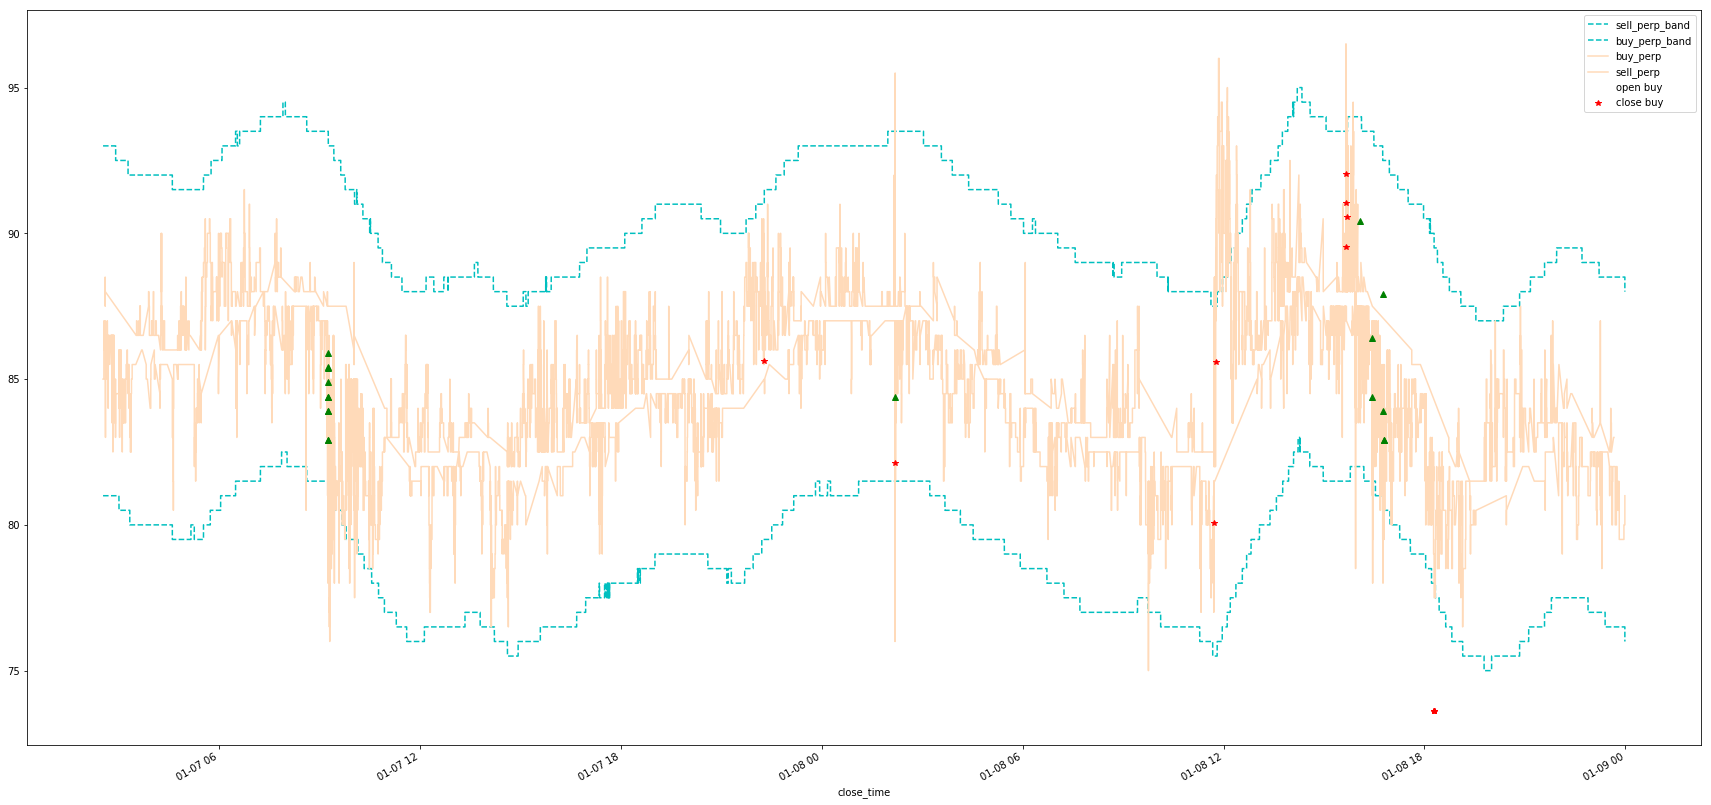

In [111]:
trades = test.copy()
start = datetime.datetime(2019,1,7)
end = start+datetime.timedelta(days=2)
data = seg[(seg["timestamp"]>start) & (seg["timestamp"]<end)]
data_buy = data[data["buy_perp"]<data["spread_mid_avg_rolling"]]
data_sell = data[data["sell_perp"]>data["spread_mid_avg_rolling"]]
trades = trades[(trades["open_time"]>start) & (trades["open_time"]<end)]
trades = trades[(trades["close_time"]>start) & (trades["close_time"]<end)]

sells = trades[trades["direction"]=="sell"]
buys = trades[trades["direction"]=="buy"]
ax = data.plot(x="timestamp",y=["sell_perp_band","buy_perp_band"],style=["c--","c--"],figsize=(30,15))
data_buy.plot(x="timestamp",y="buy_perp",style="peachpuff",ax=ax)
data_sell.plot(x="timestamp",y="sell_perp",style="peachpuff",ax=ax)


try:
    sells.plot(x="open_time",y="s_entry",label="open sell",style="rv",ax=ax)
except:
    None
try:
    sells.plot(x="close_time",y="b_entry",label="close sell",style="g*",ax=ax)
except:
    None
try:
    buys.plot(x="open_time",y="b_entry",label="open buy",style="g^",ax=ax)
except:
    None
try:
    buys.plot(x="close_time",y="s_entry",label="close buy",style="r*",ax=ax)
except:
    None

In [ ]:
sells = trades[trades["direction"]=="sell"]
#sells["price_bucket"] = pd.cut(sells["s_entry"],bins=15)
#sells = sells.groupby("price_bucket").sum()
buys = trades[trades["direction"]=="buy"]
#buys["price_bucket"] = pd.cut(buys["b_entry"],bins=15)
#buys = buys.groupby("price_bucket").sum()

sells.plot.scatter(x="profit",y="mov_avg_speed",title="sells")
buys.plot.scatter(x="profit",y="mov_avg_speed",title="buys")

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


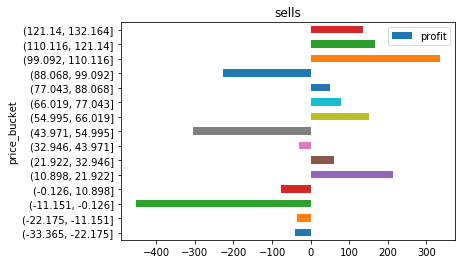

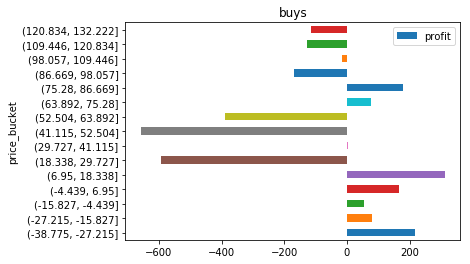

In [42]:
sells = trades[trades["direction"]=="sell"]
sells["price_bucket"] = pd.cut(sells["s_entry"],bins=15)
sells = sells.groupby("price_bucket").sum()
buys = trades[trades["direction"]=="buy"]
buys["price_bucket"] = pd.cut(buys["b_entry"],bins=15)
buys = buys.groupby("price_bucket").sum()

sells.plot.barh(y="profit",title="sells")
buys.plot.barh(y="profit",title="buys")

In [6]:
margin = [x/100 for x in margins]
data = pd.read_csv("trade_times_final_results.csv")
initial_size = {}
dropped_size = {}
dropped_values = {}
final_list = []
for mov in mov_avgs:
    for marg in margin:
        best = data[(data["mov_avg"]==mov) & (data["margin"]==marg)].iloc[0]["trade times"]
        t1 = best[1:-1].split(",")
        t1 = [x.replace("'","") for x in t1]
        initial_size[(mov,marg)] = len(t1)
        dropped_size[(mov,marg)] = len(set(t1))
        dropped_values[(mov,marg)] = t1
        final_list.append(t1)
                      
print(dropped_size)
print("total individual trades",sum(dropped_size.values()))
full_list = []
for x in final_list:
    full_list += x
print("combined trades",len(set(full_list)))

unique_list = {}
for row,values_row in dropped_values.items():
    unique = {}
    for col,values_col in dropped_values.items():
        unique[col] = len(set(values_col+values_row))
    unique_list[row] =unique
data = pd.DataFrame(unique_list)   
data

{(60, 0.0006): 7445, (60, 0.0008): 4985, (60, 0.001): 3435, (60, 0.0012): 2331, (60, 0.0015): 1445, (80, 0.0006): 7191, (80, 0.0008): 4925, (80, 0.001): 3417, (80, 0.0012): 2419, (80, 0.0015): 1459, (150, 0.0006): 6369, (150, 0.0008): 4455, (150, 0.001): 3133, (150, 0.0012): 2264, (150, 0.0015): 1493, (300, 0.0006): 4881, (300, 0.0008): 3579, (300, 0.001): 2571, (300, 0.0012): 1917, (300, 0.0015): 1309}
total individual trades 71023
combined trades 15048


60                                 80                        \
           0.0006 0.0008 0.0010 0.0012 0.0015 0.0006 0.0008 0.0010 0.0012   
60  0.0006   7445   8200   8364   8250   8093   8797   8445   8533   8454   
    0.0008   8200   4985   5529   5583   5524   8232   5971   5707   5757   
    0.0010   8364   5529   3435   3779   3858   8205   5685   4161   3931   
    0.0012   8250   5583   3779   2331   2613   8024   5601   3935   2893   
    0.0015   8093   5524   3858   2613   1445   7820   5491   3878   2772   
80  0.0006   8797   8232   8205   8024   7820   7191   8047   8182   8124   
    0.0008   8445   5971   5685   5601   5491   8047   4925   5500   5614   
    0.0010   8533   5707   4161   3935   3878   8182   5500   3417   3809   
    0.0012   8454   5757   3931   2893   2772   8124   5614   3809   2419   
    0.0015   8179   5602   3920   2676   1787   7868   5488   3831   2692   
150 0.0006  10054   8454   7778   7368   7037   9312   8104   7598   7344   
    0.0008   9186   6972   5983   5488   5107   8670   6545   5712   5392   
    0.0010   8801   6268   4861   4177   3770   8522   5981   4600   4048   
    0.0012   8631   6008   4382   3447   2933   8371   5861   4209   3334   
    0.0015   8348   5765   4108   2982   2213   8117   5733   4081   2976   
300 0.0006  10008   8011   6889   6234   5726   9567   7798   6767   6214   
    0.0008   9256   7023   5751   4984   4452   8908   6821   5604   4956   
    0.0010   8752   6352   4966   4067   3466   8523   6197   4844   4042   
    0.0012   8511   5994   4475   3505   2834   8280   5920   4384   3498   
    0.0015   8251   5719   4129   3070   2301   8034   5688   4087   3095   

                     150                                300                \
           0.0015 0.0006 0.0008 0.0010 0.0012 0.0015 0.0006 0.0008 0.0010   
60  0.0006   8179  10054   9186   8801   8631   8348  10008   9256   8752   
    0.0008   5602   8454   6972   6268   6008   5765   8011   7023   6352   
    0.0010   3920   7778   5983   4861   4382   4108   6889   5751   4966   
    0.0012   2676   7368   5488   4177   3447   2982   6234   4984   4067   
    0.0015   1787   7037   5107   3770   2933   2213   5726   4452   3466   
80  0.0006   7868   9312   8670   8522   8371   8117   9567   8908   8523   
    0.0008   5488   8104   6545   5981   5861   5733   7798   6821   6197   
    0.0010   3831   7598   5712   4600   4209   4081   6767   5604   4844   
    0.0012   2692   7344   5392   4048   3334   2976   6214   4956   4042   
    0.0015   1459   6999   5046   3687   2822   2120   5694   4411   3425   
150 0.0006   6999   6369   7324   7500   7420   7237   8273   7841   7690   
    0.0008   5046   7324   4455   5094   5255   5232   6960   5927   5482   
    0.0010   3687   7500   5094   3133   3582   3747   6330   5005   4184   
    0.0012   2822   7420   5255   3582   2264   2714   5982   4628   3653   
    0.0015   2120   7237   5232   3747   2714   1493   5702   4361   3328   
300 0.0006   5694   8273   6960   6330   5982   5702   4881   5784   5948   
    0.0008   4411   7841   5927   5005   4628   4361   5784   3579   4157   
    0.0010   3425   7690   5482   4184   3653   3328   5948   4157   2571   
    0.0012   2783   7498   5368   3876   3083   2662   5871   4304   3009   
    0.0015   2274   7259   5270   3810   2807   2084   5700   4306   3190   

                          
           0.0012 0.0015  
60  0.0006   8511   8251  
    0.0008   5994   5719  
    0.0010   4475   4129  
    0.0012   3505   3070  
    0.0015   2834   2301  
80  0.0006   8280   8034  
    0.0008   5920   5688  
    0.0010   4384   4087  
    0.0012   3498   3095  
    0.0015   2783   2274  
150 0.0006   7498   7259  
    0.0008   5368   5270  
    0.0010   3876   3810  
    0.0012   3083   2807  
    0.0015   2662   2084  
300 0.0006   5871   5700  
    0.0008   4304   4306  
    0.0010   3009   3190  
    0.0012   1917   2330  
    0.0015   2330   1309

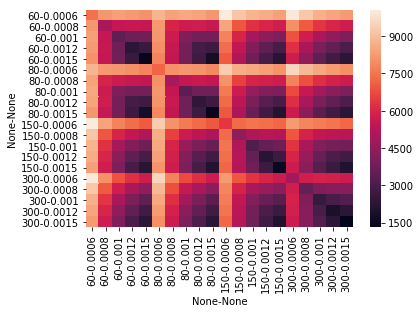

In [7]:
import seaborn as sns
sns.heatmap(data)